# 1D Schrödinger PINN vs. Exact Solution Comparison

This notebook trains the 1D Schrödinger PINN and compares its predictions against the analytic infinite‐well eigenstate at a fixed time.

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# --- Define the PINN Model ---
hbar = 1.0
m = 1.0
L = 1.0
T = 1.0

class SchrodingerPINN1D(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        X = torch.cat([x, t], dim=1)
        u = X
        for layer in self.layers[:-1]:
            u = self.activation(layer(u))
        return self.layers[-1](u)

def V_func(x):
    return torch.zeros_like(x)

def schrodinger_residual(model, x, t):
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)
    psi = model(x, t)
    psi_r, psi_i = psi[:,0:1], psi[:,1:2]
    psi_r_t = autograd.grad(psi_r, t, torch.ones_like(psi_r), create_graph=True)[0]
    psi_i_t = autograd.grad(psi_i, t, torch.ones_like(psi_i), create_graph=True)[0]
    psi_r_x = autograd.grad(psi_r, x, torch.ones_like(psi_r), create_graph=True)[0]
    psi_r_xx = autograd.grad(psi_r_x, x, torch.ones_like(psi_r_x), create_graph=True)[0]
    psi_i_x = autograd.grad(psi_i, x, torch.ones_like(psi_i), create_graph=True)[0]
    psi_i_xx = autograd.grad(psi_i_x, x, torch.ones_like(psi_i_x), create_graph=True)[0]
    V = V_func(x)
    res_r =  hbar * psi_i_t + (hbar**2/(2*m)) * psi_r_xx - V * psi_r
    res_i = -hbar * psi_r_t + (hbar**2/(2*m)) * psi_i_xx - V * psi_i
    return res_r, res_i

# Sampling
def sample_domain(N):
    x = torch.rand(N,1) * L
    t = torch.rand(N,1) * T
    return x, t

def sample_initial(N):
    x = torch.rand(N,1) * L
    t = torch.zeros_like(x)
    return x, t

def sample_boundary(N):
    t0 = torch.rand(N,1) * T
    x0 = torch.zeros(N,1)
    xL = torch.full((N,1), L)
    return x0, t0, xL, t0


In [17]:
# --- Build & Train ---
layers = [2, 64, 64, 64, 2]
model = SchrodingerPINN1D(layers)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 20000
for epoch in range(1, epochs+1):
    x_r, t_r = sample_domain(2000)
    res_r, res_i = schrodinger_residual(model, x_r, t_r)
    loss_pde = (res_r**2 + res_i**2).mean()
    x_i, t_i = sample_initial(1000)
    psi0 = np.sqrt(2/L) * torch.sin(np.pi * x_i / L)
    pred0 = model(x_i, t_i)
    loss_ic = ((pred0[:,0:1] - psi0)**2 + pred0[:,1:2]**2).mean()
    x0, t0, xL, tL = sample_boundary(1000)
    p0 = model(x0, t0); pL = model(xL, tL)
    loss_bc = (p0**2 + pL**2).mean()
    loss = loss_pde + 10*loss_ic + 10*loss_bc
    opt.zero_grad(); loss.backward(); opt.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.2e}")


Epoch 500, Loss: 5.35e-01
Epoch 1000, Loss: 2.15e-01
Epoch 1500, Loss: 7.47e-02
Epoch 2000, Loss: 2.20e-02
Epoch 2500, Loss: 1.31e-02
Epoch 3000, Loss: 1.02e-02
Epoch 3500, Loss: 4.33e-03
Epoch 4000, Loss: 4.14e-03
Epoch 4500, Loss: 4.68e-03
Epoch 5000, Loss: 2.52e-03
Epoch 5500, Loss: 2.41e-03
Epoch 6000, Loss: 5.11e-03
Epoch 6500, Loss: 1.85e-03
Epoch 7000, Loss: 1.70e-03
Epoch 7500, Loss: 4.10e-03
Epoch 8000, Loss: 1.82e-03
Epoch 8500, Loss: 2.14e-03
Epoch 9000, Loss: 2.90e-03
Epoch 9500, Loss: 1.25e-02
Epoch 10000, Loss: 1.32e-03
Epoch 10500, Loss: 1.07e-03
Epoch 11000, Loss: 1.16e-03
Epoch 11500, Loss: 1.49e-02
Epoch 12000, Loss: 2.30e-03
Epoch 12500, Loss: 5.06e-04
Epoch 13000, Loss: 7.33e-04
Epoch 13500, Loss: 2.88e-03
Epoch 14000, Loss: 5.49e-03
Epoch 14500, Loss: 5.66e-04
Epoch 15000, Loss: 1.98e-03
Epoch 15500, Loss: 5.05e-03
Epoch 16000, Loss: 6.26e-04
Epoch 16500, Loss: 4.73e-04
Epoch 17000, Loss: 3.96e-04
Epoch 17500, Loss: 1.42e-03
Epoch 18000, Loss: 1.91e-03
Epoch 18500,

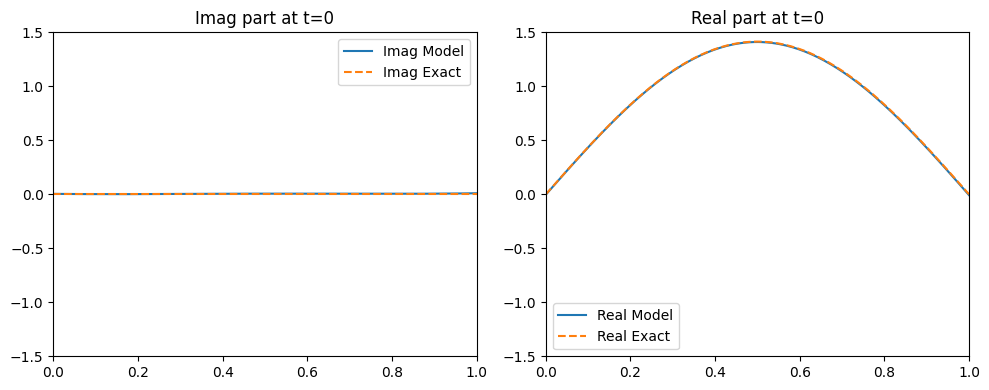

In [27]:
# --- Compare at t = 0.1 ---
t_plot = 0
n = 200
x_plot = torch.linspace(0, L, n).unsqueeze(1)
t_plot_t = torch.full_like(x_plot, t_plot)

with torch.no_grad():
    pred = model(x_plot, t_plot_t).numpy()

psi_r_pred = pred[:,0]
psi_i_pred = pred[:,1]
# Exact infinite-well n=1
E1 = (np.pi**2 * hbar**2)/(2*m*L**2)
psi_exact = np.sqrt(2/L) * np.sin(np.pi * x_plot.numpy() / L) * np.exp(-1j*E1*t_plot)
psi_r_ex = np.real(psi_exact).flatten()
psi_i_ex = np.imag(psi_exact).flatten()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x_plot, -psi_i_pred, label='Imag Model')
plt.plot(x_plot, psi_i_ex, '--', label='Imag Exact')
plt.title(f'Imag part at t={t_plot}')
plt.xlim(0, L)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.subplot(1,2,2)
plt.plot(x_plot, psi_r_pred, label='Real Model')
plt.plot(x_plot, psi_r_ex, '--', label='Real Exact')
plt.title(f'Real part at t={t_plot}')
plt.xlim(0, L)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.tight_layout()
plt.show()
